In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 

import cptac
import cptac.utils as u

In [2]:
c1 = cptac.Endometrial()
c2 = cptac.Colon()

In [3]:
cancer1 = "Endometrial"
cancer2 = "Colon"
gene = 'TP53'

In [4]:
#GBM ttest
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
prot = c1.get_proteomics()
prot_list = list(prot.columns)
prot_and_mutations = c1.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = prot_list)  

# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status = mut_status.dropna(axis=1,how='all')

In [5]:
col_list = list(mut_status.columns)
col_list.remove('binary_mutations')

print("Doing t-test comparisons for", cancer1)
print('Bonferroni:', .05/len(col_list))

# Call wrap_ttest, pass in formatted dataframe
wrap_results = u.wrap_ttest(mut_status, 'binary_mutations', col_list, return_all=True)

C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Doing t-test comparisons for Endometrial
135 significant comparisons!


In [6]:
print(wrap_results.loc[wrap_results['Comparison'] == gene+"_proteomics"])
wrap_results

         Comparison       P_Value
64  TP53_proteomics  3.991072e-07


,Comparison,P_Value
0,MTHFD2_proteomics,9.298849e-12
1,SLC4A1AP_proteomics,5.983585e-11
2,XPO5_proteomics,1.551177e-10
3,TRMT6_proteomics,1.801163e-10
4,STAT2_proteomics,1.922167e-10
...,...,...
10988,KCTD13_proteomics,9.885735e-01
10989,TSSC4_proteomics,9.923845e-01
10990,KRCC1_proteomics,9.942184e-01
10991,METTL7B_proteomics,9.995390e-01


In [7]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
prot2 = c2.get_proteomics()
prot_list2 = list(prot2.columns)
prot_and_mutations = c2.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = prot_list2)  

# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status2 = mut_status.dropna(axis=1,how='all')

In [8]:
col_list2 = list(mut_status2.columns)
col_list2.remove('binary_mutations')

print("Doing t-test comparisons for", cancer2)

# Call wrap_ttest, pass in formatted dataframe
wrap_results2 = u.wrap_ttest(mut_status2, 'binary_mutations', col_list2, return_all=True)

Doing t-test comparisons for Colon
No significant comparisons.


In [9]:
print(wrap_results2.loc[wrap_results2['Comparison'] == gene+"_proteomics"])
wrap_results2

           Comparison   P_Value
7329  TP53_proteomics  0.844406


,Comparison,P_Value
0,ASCC3_proteomics,0.000141
1,EAPP_proteomics,0.000974
2,EIF6_proteomics,0.002096
3,GHDC_proteomics,0.002608
4,ESPN_proteomics,0.003419
...,...,...
8062,MAT2B_proteomics,0.996511
8063,RTN1_proteomics,0.996535
8064,TM9SF2_proteomics,0.998232
8065,YTHDC2_proteomics,0.999204


In [10]:
#combine pval results
combined = wrap_results.merge(wrap_results2, on='Comparison')
combined = combined.replace(regex=True,to_replace='_proteomics', value='')

In [11]:
# Green = interacting protein
interacting_list = u.get_interacting_proteins(gene)
combined["color"] = np.where(combined["Comparison"].isin(interacting_list), "green", "black")
print(interacting_list)
#combined.loc[combined['color'] == 'green']

['RPA1', 'AURKA', 'MDM2', 'SIRT1', 'CREBBP', 'EP300', 'CDK2', 'TP53', 'ATM', 'BCL2L1', 'TP53BP2', 'CCNG1', 'MDM4', 'PTEN', 'TP53BP1', 'CHEK2', 'FZR1', 'MAPK8', 'KDM1A', 'BCL6', 'CDKN1A', 'HIPK2', 'CHEK1', 'CDKN2A', 'BRCA1', 'AKT1', 'DVL2', 'BLM', 'ATR', 'TFAP2A', 'EPHA3']


In [12]:
limit_x = combined.loc[combined['P_Value_x'] <= .05]
limit_y = combined.loc[combined['P_Value_y'] <= .05]
limit_both = limit_x.loc[limit_x['P_Value_y'] <= .05]
print(limit_both.loc[limit_both['color'] == 'green'])
limit_both

Empty DataFrame
Columns: [Comparison, P_Value_x, P_Value_y, color]
Index: []


,Comparison,P_Value_x,P_Value_y,color
29,ARFIP2,7.383859e-08,0.003363,black
50,TPD52L2,2.430440e-07,0.037359,black
65,OGFR,5.502492e-07,0.042275,black
69,ISG15,6.390668e-07,0.046613,black
71,DDX27,6.655045e-07,0.026192,black
...,...,...,...,...
7289,UBE2S,1.611571e-04,0.000331,black
7372,UTP11,4.544480e-03,0.024454,black
7466,YWHAB,2.698555e-03,0.018102,black
7468,YWHAE,3.706101e-03,0.045077,black


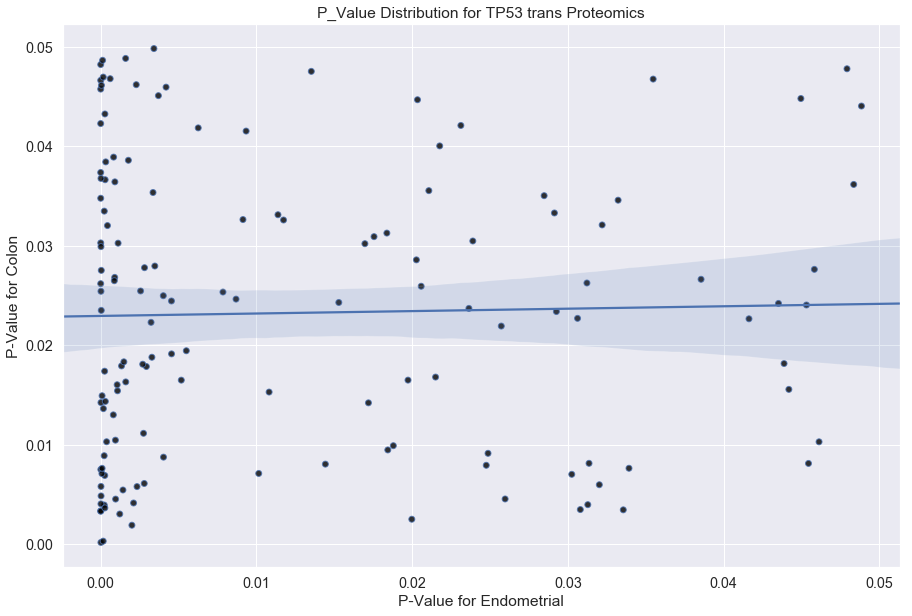

In [13]:
# Format figure size and font
plt.rcParams['figure.figsize']=(15,10)
sns.set(font_scale = 1.3)

# Format title and axis
plot = sns.regplot(x="P_Value_x", y="P_Value_y", data=limit_both, scatter_kws={'facecolors':limit_both['color']})
plot.set_title("P_Value Distribution for "+gene+" trans Proteomics")
plot.set(xlabel = 'P-Value for '+cancer1)
plot.set(ylabel = 'P-Value for '+cancer2)

plt.show()
plt.clf()
plt.close()

TP53: 135 significant results for endometrial. No significant results for colon. 0 interacting proteins in graph with alpha = 0.05 borders.